##### Plot posterior pdf, lik function and prior for a given hyperparameter value

In [1]:
#!/usr/bin/python
import numpy as np
import numpy.linalg as la
import scipy.stats as st
import scipy.optimize as sopt
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, math, sys
np.random.seed(88)
#os.system('rm *.pdf *.eps *.png');

In [2]:
K = 2
Nphi = 2
acoeff  = np.ones((1,K))
mu  = np.zeros((Nphi,K))
Sig = np.zeros((Nphi,Nphi,K))
mu[0,0] = 1.0
mu[1,1] = 1.0
rho = -0.9
var = 0.05
fac = 0.25
Sig[:,:,0] = [[var,var*rho],[var*rho,var]]
Sig[:,:,1] = [[fac*var,fac*var*rho],[fac*var*rho,fac*var]]
r = 1e-04
s = 1e-04

In [3]:
Bmat = np.zeros((Nphi,Nphi,K))
Pmat = np.zeros((Nphi,Nphi,K))
mVec = np.zeros((Nphi,K))
Wraw = np.zeros((1,K))
Vmat = np.zeros((Nphi,K))
LEjvec = np.zeros((Nphi,1))
jVec = np.zeros((Nphi,1))
Hmat = np.zeros((Nphi,Nphi))

In [4]:
def poststat(X,logalp):
    alp = np.exp(logalp)
    A = np.diag(alp)
    Ain = np.diag(1/alp)
    for i in range(0,K):
        Bmat[:,:,i] = Sig[:,:,i] + Ain
        Wraw[0,i] = acoeff[0,i]*st.multivariate_normal.pdf(mu[:,i],[0]*Nphi,Bmat[:,:,i])
        Pmat[:,:,i] = Ain - Ain@la.inv(Bmat[:,:,i])@Ain
        mVec[:,i] = Pmat[:,:,i]@la.inv(Sig[:,:,i])@mu[:,i]
        for j in range(0,Nphi):
            Vmat[j,i] = (1 - alp[j]*Pmat[j,j,i] - alp[j]*(mVec[j,i]**2))/(2.0*alp[j])
    LogEvid= np.log(np.sum(Wraw))
    ObjFun = LogEvid + np.sum(r*logalp-s*alp)
    Wwght = Wraw/np.sum(Wraw)
    for i in range(0,Nphi):
        LEjvec[i,0] = np.dot(Wwght,Vmat[i,:])
        jVec[i,0]   = alp[i]*LEjvec[i,0] + r - s*alp[i]
    PostPdf = 0.0
    LikFun = 0.0
    for i in range(0,K):
        LikFun  = LikFun  + acoeff[0,i]*st.multivariate_normal.pdf(X,mu[:,i],Sig[:,:,i])
        PostPdf = PostPdf + Wwght[0,i]*st.multivariate_normal.pdf(X,mVec[:,i],Pmat[:,:,i])  
    PriorPdf = st.multivariate_normal.pdf(X,[0]*Nphi,Ain)
    for i in range(0,Nphi):
        for j in range(0,Nphi):
            temp = 0.0
            for k in range(0,K):
                temp = temp + Wwght[0,k]*(0.5*Pmat[i,j,k]**2 + Vmat[j,k]*(Vmat[i,k] - LEjvec[i,0])) 
            Hmat[i,j] = logalp[i]*logalp[j]*temp
    return PriorPdf, LikFun, PostPdf, LogEvid, ObjFun, jVec, Hmat

In [5]:
Ngrd  = 100
LFgrd = np.zeros((Ngrd,Ngrd))
PSgrd = np.zeros((Ngrd,Ngrd))
PRgrd = np.zeros((Ngrd,Ngrd))
checkLevid = np.zeros((Ngrd,Ngrd))
X1bnd = [-1,2]
X2bnd = [-1,2]
X1rng = np.linspace(X1bnd[0],X1bnd[1],Ngrd)
X2rng = np.linspace(X2bnd[0],X2bnd[1],Ngrd)
X1grd,X2grd = np.meshgrid(X1rng,X2rng)
atLogAlp = np.array([-2,-2])
for i in range(0,Ngrd):
    for j in range(0, Ngrd):
        Xcur = np.array([X1grd[i,j],X2grd[i,j]])
        PRgrd[i,j], LFgrd[i,j], PSgrd[i,j], Levid, Obfun, JacVec, Hmt = poststat(Xcur,atLogAlp)
        checkLevid[i,j] =  LFgrd[i,j]*PRgrd[i,j]
LevidEst = np.log(np.sum(checkLevid)*(X1rng[1]-X1rng[0])*(X2rng[1]-X2rng[0]))
print(Levid,LevidEst)

-3.2163189208568284 -3.2163207445049706


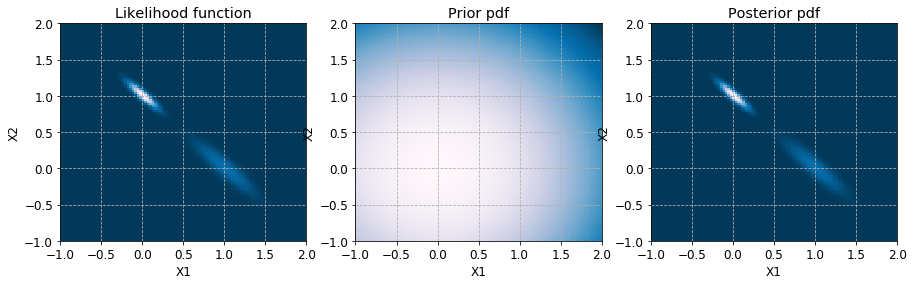

In [6]:
mpl.rcParams.update({'font.size':12})
fig=plt.figure(1,figsize=(15,4))
plt.subplot(1, 3, 1)
plt.pcolor(X1grd,X2grd,LFgrd,cmap='PuBu_r')
#plt.colorbar()
plt.grid('on',linestyle='--')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Likelihood function')

plt.subplot(1, 3, 2)
plt.pcolor(X1grd,X2grd,PRgrd,cmap='PuBu_r')
#plt.colorbar()
plt.grid('on',linestyle='--')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Prior pdf')

plt.subplot(1, 3, 3)
plt.pcolor(X1grd,X2grd,PSgrd,cmap='PuBu_r')
#plt.colorbar()
plt.grid('on',linestyle='--')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Posterior pdf')
plt.savefig('plot_post.eps',bbox_inches='tight')